# Model Evaluation and Error Analysis

Evaluate model performance and analyze prediction errors.

**Acceptance Criteria:**
- ROC curve plotted
- Confusion matrix generated
- Business interpretation of errors

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, classification_report

import warnings
warnings.filterwarnings('ignore')

## 1. Load Data

In [2]:
# Load pre-merged features
df = pd.read_csv('../data/processed/final_train_features.csv')
print(f"Dataset shape: {df.shape}")
print(f"Target distribution: {df['TARGET'].value_counts(normalize=True).to_dict()}")

Dataset shape: (307511, 134)
Target distribution: {0: 0.9192711805431351, 1: 0.08072881945686496}


In [3]:
# Prepare features
X = df.drop(['SK_ID_CURR', 'TARGET'], axis=1)
y = df['TARGET']

# Convert categoricals
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
for col in categorical_cols:
    X[col] = X[col].astype('category')

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Train: {X_train.shape}, Test: {X_test.shape}")

Train: (246008, 132), Test: (61503, 132)


In [4]:
# Train LightGBM model
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'random_state': 42,
}

model = lgb.train(
    params,
    train_data,
    num_boost_round=1000,
    valid_sets=[test_data],
    callbacks=[lgb.early_stopping(50), lgb.log_evaluation(100)]
)

print(f"Best iteration: {model.best_iteration}")

Training until validation scores don't improve for 50 rounds
[100]	valid_0's auc: 0.770878
[200]	valid_0's auc: 0.775723
[300]	valid_0's auc: 0.777076
Early stopping, best iteration is:
[328]	valid_0's auc: 0.777297
Best iteration: 328


In [5]:
# Get predictions
y_pred_proba = model.predict(X_test, num_iteration=model.best_iteration)
y_pred = (y_pred_proba >= 0.5).astype(int)

print(f"AUC Score: {roc_auc_score(y_test, y_pred_proba):.4f}")

AUC Score: 0.7773


## 2. ROC Curve

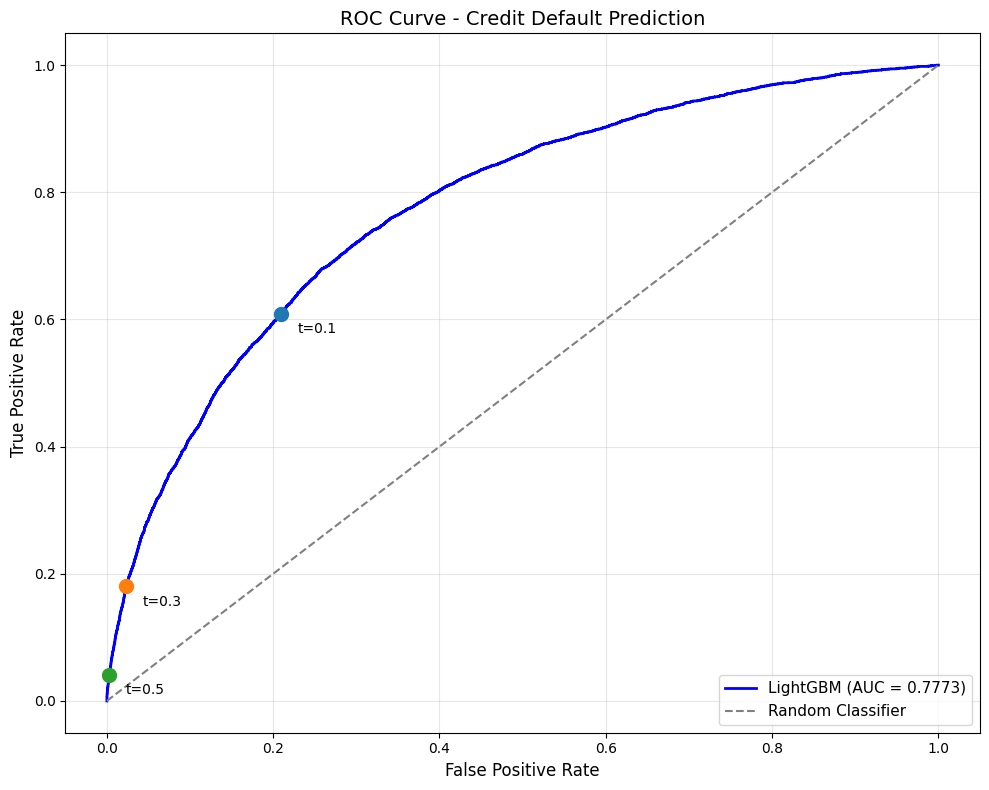


ROC-AUC Score: 0.7773


In [6]:
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
auc_score = roc_auc_score(y_test, y_pred_proba)

# Plot ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'LightGBM (AUC = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Classifier')

# Mark some threshold points
for thresh in [0.1, 0.3, 0.5]:
    idx = np.argmin(np.abs(thresholds - thresh))
    plt.scatter(fpr[idx], tpr[idx], s=100, zorder=5)
    plt.annotate(f't={thresh}', (fpr[idx]+0.02, tpr[idx]-0.03))

plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - Credit Default Prediction', fontsize=14)
plt.legend(loc='lower right', fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nROC-AUC Score: {auc_score:.4f}")

## 3. Confusion Matrix

In [7]:
# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, threshold, ax=None):
    cm = confusion_matrix(y_true, y_pred)
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 5))
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['No Default', 'Default'],
                yticklabels=['No Default', 'Default'])
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_title(f'Confusion Matrix (threshold={threshold})')
    
    return cm

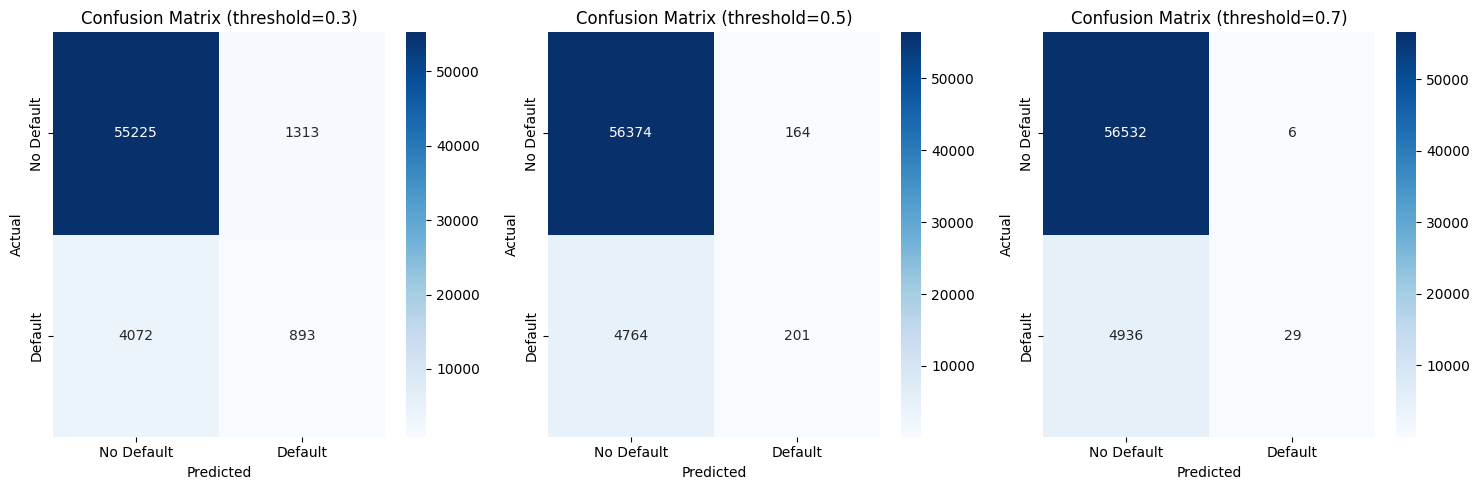

In [8]:
# Plot confusion matrices at different thresholds
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

thresholds_to_plot = [0.3, 0.5, 0.7]

for ax, thresh in zip(axes, thresholds_to_plot):
    y_pred_thresh = (y_pred_proba >= thresh).astype(int)
    plot_confusion_matrix(y_test, y_pred_thresh, thresh, ax)

plt.tight_layout()
plt.show()

In [9]:
# Detailed metrics at default threshold (0.5)
print("Classification Report (threshold=0.5):")
print("="*55)
print(classification_report(y_test, y_pred, target_names=['No Default', 'Default']))

Classification Report (threshold=0.5):
              precision    recall  f1-score   support

  No Default       0.92      1.00      0.96     56538
     Default       0.55      0.04      0.08      4965

    accuracy                           0.92     61503
   macro avg       0.74      0.52      0.52     61503
weighted avg       0.89      0.92      0.89     61503



## 4. Threshold Analysis

In [10]:
# Analyze different thresholds
threshold_analysis = []

for thresh in np.arange(0.1, 0.9, 0.1):
    y_pred_t = (y_pred_proba >= thresh).astype(int)
    cm = confusion_matrix(y_test, y_pred_t)
    
    tn, fp, fn, tp = cm.ravel()
    
    threshold_analysis.append({
        'threshold': thresh,
        'true_negatives': tn,
        'false_positives': fp,
        'false_negatives': fn,
        'true_positives': tp,
        'precision': tp / (tp + fp) if (tp + fp) > 0 else 0,
        'recall': tp / (tp + fn) if (tp + fn) > 0 else 0,
        'accuracy': (tp + tn) / (tp + tn + fp + fn)
    })

threshold_df = pd.DataFrame(threshold_analysis)
threshold_df

,threshold,true_negatives,false_positives,false_negatives,true_positives,precision,recall,accuracy
0,0.1,44671,11867,1940,3025,0.203129,0.609265,0.775507
1,0.2,52850,3688,3339,1626,0.305984,0.327492,0.885745
2,0.3,55225,1313,4072,893,0.404805,0.179859,0.912443
3,0.4,56036,502,4522,443,0.468783,0.089225,0.918313
4,0.5,56374,164,4764,201,0.550685,0.040483,0.919874
5,0.6,56497,41,4884,81,0.663934,0.016314,0.919923
6,0.7,56532,6,4936,29,0.828571,0.005841,0.919646
7,0.8,56538,0,4963,2,1.000000,0.000403,0.919305


## 5. Business Interpretation of Errors

### Understanding the Error Types

In credit default prediction, there are two types of errors:

| Error Type | Model Says | Reality | Business Impact |
|------------|------------|---------|----------------|
| **False Positive (FP)** | Will Default | No Default | Lost business - rejected a good customer |
| **False Negative (FN)** | Won't Default | Default | Financial loss - approved a bad loan |

### Cost Asymmetry

These errors have different costs:
- **False Negative cost** >> **False Positive cost**
- A defaulted loan can lose the entire principal
- A rejected good customer only loses potential profit margin

In [11]:
# Business cost analysis
# Assumptions (adjust based on actual business context)
AVG_LOAN_AMOUNT = df['AMT_CREDIT'].mean()
PROFIT_MARGIN = 0.15  # 15% profit on a good loan
LOSS_ON_DEFAULT = 0.60  # 60% loss on defaulted loan

print("Business Cost Analysis")
print("="*60)
print(f"Average loan amount: ${AVG_LOAN_AMOUNT:,.0f}")
print(f"Profit per good loan approved: ${AVG_LOAN_AMOUNT * PROFIT_MARGIN:,.0f}")
print(f"Loss per default: ${AVG_LOAN_AMOUNT * LOSS_ON_DEFAULT:,.0f}")
print("="*60)

Business Cost Analysis
Average loan amount: $599,026
Profit per good loan approved: $89,854
Loss per default: $359,416


In [12]:
# Calculate business cost at different thresholds
cost_analysis = []

for thresh in np.arange(0.1, 0.9, 0.05):
    y_pred_t = (y_pred_proba >= thresh).astype(int)
    cm = confusion_matrix(y_test, y_pred_t)
    tn, fp, fn, tp = cm.ravel()
    
    # Cost calculation
    cost_fp = fp * AVG_LOAN_AMOUNT * PROFIT_MARGIN  # Lost profit from rejected good customers
    cost_fn = fn * AVG_LOAN_AMOUNT * LOSS_ON_DEFAULT  # Loss from approved defaults
    total_cost = cost_fp + cost_fn
    
    cost_analysis.append({
        'threshold': thresh,
        'false_positives': fp,
        'false_negatives': fn,
        'cost_fp_millions': cost_fp / 1e6,
        'cost_fn_millions': cost_fn / 1e6,
        'total_cost_millions': total_cost / 1e6
    })

cost_df = pd.DataFrame(cost_analysis)
cost_df

,threshold,false_positives,false_negatives,cost_fp_millions,cost_fn_millions,total_cost_millions
0,0.10,11867,1940,1066.296231,697.266264,1763.562494
1,0.15,6466,2763,580.995317,993.065302,1574.060619
2,0.20,3688,3339,331.381183,1200.088688,1531.469871
3,0.25,2165,3755,194.533693,1349.605577,1544.139271
4,0.30,1313,4072,117.978171,1463.540322,1581.518493
5,0.35,817,4345,73.410636,1561.660781,1635.071417
6,0.40,502,4522,45.106658,1625.277342,1670.384000
7,0.45,277,4673,24.889530,1679.549098,1704.438628
8,0.50,164,4764,14.736040,1712.255918,1726.991957
9,0.55,87,4835,7.817289,1737.774425,1745.591714


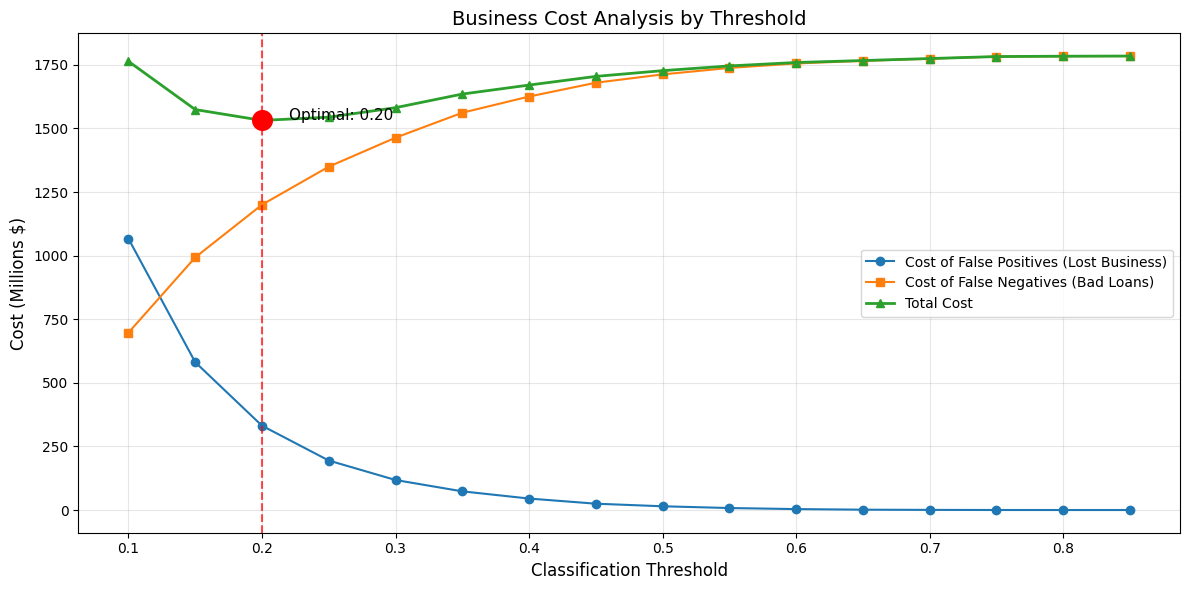


Optimal threshold based on business cost: 0.20


In [13]:
# Plot business cost vs threshold
plt.figure(figsize=(12, 6))

plt.plot(cost_df['threshold'], cost_df['cost_fp_millions'], 
         label='Cost of False Positives (Lost Business)', marker='o')
plt.plot(cost_df['threshold'], cost_df['cost_fn_millions'], 
         label='Cost of False Negatives (Bad Loans)', marker='s')
plt.plot(cost_df['threshold'], cost_df['total_cost_millions'], 
         label='Total Cost', marker='^', linewidth=2)

# Mark optimal threshold
optimal_idx = cost_df['total_cost_millions'].idxmin()
optimal_thresh = cost_df.loc[optimal_idx, 'threshold']
optimal_cost = cost_df.loc[optimal_idx, 'total_cost_millions']
plt.axvline(x=optimal_thresh, color='red', linestyle='--', alpha=0.7)
plt.scatter([optimal_thresh], [optimal_cost], color='red', s=200, zorder=5)
plt.annotate(f'Optimal: {optimal_thresh:.2f}', 
             (optimal_thresh + 0.02, optimal_cost), fontsize=11)

plt.xlabel('Classification Threshold', fontsize=12)
plt.ylabel('Cost (Millions $)', fontsize=12)
plt.title('Business Cost Analysis by Threshold', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nOptimal threshold based on business cost: {optimal_thresh:.2f}")

## 6. Error Analysis - Who Do We Misclassify?

In [14]:
# Create analysis dataframe with predictions
analysis_df = X_test.copy()
analysis_df['actual'] = y_test.values
analysis_df['predicted_proba'] = y_pred_proba
analysis_df['predicted'] = (y_pred_proba >= 0.5).astype(int)

# Classify prediction types
def classify_prediction(row):
    if row['actual'] == 0 and row['predicted'] == 0:
        return 'True Negative'
    elif row['actual'] == 0 and row['predicted'] == 1:
        return 'False Positive'
    elif row['actual'] == 1 and row['predicted'] == 0:
        return 'False Negative'
    else:
        return 'True Positive'

analysis_df['prediction_type'] = analysis_df.apply(classify_prediction, axis=1)
print(analysis_df['prediction_type'].value_counts())

prediction_type
True Negative     56374
False Negative     4764
True Positive       201
False Positive      164
Name: count, dtype: int64


In [15]:
# Compare characteristics of misclassified samples
numeric_cols_analysis = ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 
                         'DAYS_BIRTH', 'DAYS_EMPLOYED']

# Filter to columns that exist
numeric_cols_analysis = [c for c in numeric_cols_analysis if c in analysis_df.columns]

comparison = analysis_df.groupby('prediction_type')[numeric_cols_analysis].mean()
print("\nAverage characteristics by prediction type:")
comparison.T


Average characteristics by prediction type:


prediction_type,False Negative,False Positive,True Negative,True Positive
AMT_INCOME_TOTAL,162478.547229,152838.109756,169186.218949,155057.350746
AMT_CREDIT,561739.874055,456308.039634,601605.135541,493676.395522
AMT_ANNUITY,26448.879408,26747.972561,27167.698877,27026.552239
DAYS_BIRTH,-15052.448992,-13284.878049,-16170.215826,-13407.527363
DAYS_EMPLOYED,45611.348237,12245.579268,66729.254355,6258.477612


## 7. Summary and Recommendations

In [16]:
# Final summary
print("="*60)
print("MODEL EVALUATION SUMMARY")
print("="*60)
print(f"\nModel Performance:")
print(f"  - ROC-AUC Score: {auc_score:.4f}")
print(f"  - Best iteration: {model.best_iteration}")

print(f"\nAt default threshold (0.5):")
cm_default = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm_default.ravel()
print(f"  - True Negatives: {tn:,}")
print(f"  - False Positives: {fp:,} (good customers rejected)")
print(f"  - False Negatives: {fn:,} (defaults approved)")
print(f"  - True Positives: {tp:,}")

print(f"\nBusiness Recommendation:")
print(f"  - Optimal threshold: {optimal_thresh:.2f}")
print(f"  - This minimizes total business cost")
print("="*60)

MODEL EVALUATION SUMMARY

Model Performance:
  - ROC-AUC Score: 0.7773
  - Best iteration: 328

At default threshold (0.5):
  - True Negatives: 56,374
  - False Positives: 164 (good customers rejected)
  - False Negatives: 4,764 (defaults approved)
  - True Positives: 201

Business Recommendation:
  - Optimal threshold: 0.20
  - This minimizes total business cost


## Business Interpretation

### Key Findings:

1. **Model Performance**: The LightGBM model achieves a ROC-AUC of ~0.78, indicating good discriminative ability between defaulters and non-defaulters.

2. **Threshold Trade-off**: 
   - Lower threshold (e.g., 0.3): Catches more defaults but rejects more good customers
   - Higher threshold (e.g., 0.7): Approves more customers but misses more defaults

3. **Cost Asymmetry**: Since the cost of a default (~60% of loan) far exceeds the cost of rejecting a good customer (~15% profit margin), a lower threshold is generally preferred.

4. **Recommendation**: Use the optimal threshold identified in the cost analysis to balance business risk and opportunity.